# REMEMBER:
- ALL MODELS -> EVAL MODE!!!!

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys  # TODO: Fix this?

sys.path.append("PyTorch-StudioGAN/")
import itertools
import random

import torch
import torchvision.transforms.functional as TF
from Attacks.attacks_suite import *
from Classifiers.resnet import load_model as load_victim_model
from Defense.def_utils import *
from functools import partial

import matplotlib.pyplot as plt

import numpy as np

from gan_loader import load_model as load_gan_model
from LGDPM.diffusion_loader import load_model as load_diffusion_model
from pytorch_histogram_matching import Histogram_Matching
from torchmetrics.functional.classification import binary_auroc, multiclass_accuracy
from torchvision import datasets, transforms as T
from torchvision.utils import make_grid, save_image
from tqdm import tqdm

assert torch.cuda.is_available()


In [3]:
seed = 1
torch.backends.cudnn.enabled = True
torch.backends.cudnn.deterministic = True

random.seed(seed);
np.random.seed(seed);
torch.cuda.manual_seed(seed);
torch.manual_seed(seed);


# Load all victims

In [4]:
V_WEIGHTS = {
    "MNIST": "saved_models/victims/mnist_resnet18.pth",
    "CIFAR10": "saved_models/victims/cifar10_resnet18.pth",
    "TIMGNET": "saved_models/victims/timgnet_resnet18.pth",
}
cifar10_victim = load_victim_model(V_WEIGHTS["CIFAR10"], num_classes=10, in_channels=3)
timgnet_victim = load_victim_model(V_WEIGHTS["TIMGNET"], num_classes=200, in_channels=3)
cifar10_victim.eval()
timgnet_victim.eval()
VICTIM_MODELS = {
    "CIFAR10": cifar10_victim,
    "TIMGNET": timgnet_victim,
}


# Load defenders one at a time for testing

In [5]:
D_WEIGHTS = {
    "MNIST_DIFF": "saved_models/defenders/diffusion/mnist_diff.pth",
    "CIFAR10_DIFF": "saved_models/defenders/diffusion/cifar10_diff.pth",
    "TIMGNET_DIFF": "saved_models/defenders/diffusion/timgnet_diff.pth",
    "MNIST_ADCGAN": (
        "saved_models/defenders/acgan/mnist/G_mnist_adcgan.pth",
        "saved_models/defenders/acgan/mnist/D_mnist_adcgan.pth",
    ),
    "MNIST_REACGAN": (
        "saved_models/defenders/acgan/mnist/G_mnist_reacgan.pth",
        "saved_models/defenders/acgan/mnist/D_mnist_reacgan.pth",
    ),
    "MNIST_READCGAN": (
        "saved_models/defenders/acgan/mnist/G_mnist_readcgan.pth",
        "saved_models/defenders/acgan/mnist/D_mnist_readcgan.pth",
    ),
    "CIFAR10_ADCGAN": (
        "saved_models/defenders/acgan/cifar10/G_cifar10_adcgan.pth",
        "saved_models/defenders/acgan/cifar10/D_cifar10_adcgan.pth",
    ),
    "CIFAR10_REACGAN": (
        "saved_models/defenders/acgan/cifar10/G_cifar10_reacgan.pth",
        "saved_models/defenders/acgan/cifar10/D_cifar10_reacgan.pth",
    ),
    "CIFAR10_READCGAN": (
        "saved_models/defenders/acgan/cifar10/G_cifar10_readcgan.pth",
        "saved_models/defenders/acgan/cifar10/D_cifar10_readcgan.pth",
    ),
    "TIMGNET_ADCGAN": (
        "saved_models/defenders/acgan/timgnet/G_timgnet_adcgan.pth",
        "saved_models/defenders/acgan/timgnet/D_timgnet_adcgan.pth",
    ),
    "TIMGNET_REACGAN": (
        "saved_models/defenders/acgan/timgnet/G_timgnet_reacgan.pth",
        "saved_models/defenders/acgan/timgnet/D_timgnet_reacgan.pth",
    ),
    "TIMGNET_READCGAN": (
        "saved_models/defenders/acgan/timgnet/G_timgnet_readcgan.pth",
        "saved_models/defenders/acgan/timgnet/D_timgnet_readcgan.pth",
    ),
}

# Attack and Samples Preparation

In [6]:
def generate_sample_baskets(n_samples=200):
    all_datasets = {
        "CIFAR10": datasets.CIFAR10(
            root="PyTorch-StudioGAN/data/",
            train=False,
            transform=T.Compose(
                [
                    T.ToTensor(),
                    T.Normalize(
                        DEFAULT_MOMENTS.CIFAR10.mean, DEFAULT_MOMENTS.CIFAR10.std
                    ),
                ]
            ),
        ),
        "TIMGNET": datasets.ImageFolder(
            root="PyTorch-StudioGAN/data/tiny-imagenet-200/val/",
            transform=T.Compose(
                [
                    T.ToTensor(),
                    T.Normalize(
                        DEFAULT_MOMENTS.TIMGNET.mean, DEFAULT_MOMENTS.TIMGNET.std
                    ),
                ]
            ),
        ),
    }
    samples = {}
    for name, ds in all_datasets.items():
        targets = torch.tensor(ds.targets)
        all_classes = torch.unique(targets)
        assert (
            n_samples % len(all_classes) == 0
        ), f"Cannot sample equally with the provided n_samples={n_samples} and n_targets={len(all_classes)}"
        n_samples_per_class = n_samples // len(all_classes)
        balanced_sample_indices = []
        for cls in all_classes:
            only_cls = torch.where(targets == cls)[0].tolist()
            balanced_sample_indices.extend(
                random.sample(only_cls, n_samples_per_class)
            )
        samples.update({name: [ds[idx] for idx in balanced_sample_indices]})
    return samples


In [7]:
def generate_attacks(victim, ds_name, real_sample_baskets, targeted=False, **kwargs):
    images, labels = zip(*real_sample_baskets[ds_name])
    images, labels = torch.stack(images).to("cuda"), torch.tensor(list(labels)).to(
        "cuda", dtype=torch.long
    )
    if isinstance(targeted, bool):
        suite = partial(run_attack_suite, targets="auto" if targeted else None)
    elif isinstance(targeted, torch.Tensor):
        suite = partial(run_attack_suite, targets=targeted)
    attacks = suite(victim, ds_name, images, labels, **kwargs)
    torch.cuda.empty_cache()
    return attacks


In [8]:
### GENERATE ATTACKS TO BE USED GLOBALLY
if os.path.exists("real_sample_baskets.pth"):
    real_sample_baskets = torch.load("real_sample_baskets.pth")
else:
    real_sample_baskets = generate_sample_baskets(n_samples=1000)
    torch.save(real_sample_baskets, "real_sample_baskets.pth")
if os.path.exists("ADV_ATTACKS.pth"):
    ADV_ATTACKS = torch.load("ADV_ATTACKS.pth")
else:
    ADV_ATTACKS = {
        "CIFAR10": generate_attacks(
            cifar10_victim, "CIFAR10", real_sample_baskets, targeted=True,
        ),
        "TIMGNET": generate_attacks(
            timgnet_victim, "TIMGNET", real_sample_baskets, targeted=True,
        ),
    }
    torch.save(ADV_ATTACKS, "ADV_ATTACKS.pth")


# Final Run
- Default configs.
- Load XGB models.
- Seek & Destroy! (Detect + Purify)

In [9]:
DEFENDER_DEFAULT_CONFIGS = {
    "DIFF": {
        "CIFAR10": "CIFAR10_DIFF",
        "TIMGNET": "TIMGNET_DIFF",
        "aux_d_type_for_diff": "REACGAN",
    },
    "ACGAN":{
        "CIFAR10": "CIFAR10_REACGAN",
        "TIMGNET": "TIMGNET_REACGAN",
    }
}
BASE_PATH = "DHT_models/"

In [10]:
os.makedirs("final_results", exist_ok=True)

## Diffusion

In [11]:
NUM_SPLITS = 10
targeted_purify_kwargs = {}
max_fpr = 0.2
diff_results = {}
save_dir="final_results"
for dataset_name in ["CIFAR10", "TIMGNET"]:
    for attack_method in ["CW", "FGSM", "PGD"]:
        victim = VICTIM_MODELS[dataset_name]
        defender = DEFENDER_DEFAULT_CONFIGS["DIFF"][dataset_name]
        aux_d_name = (
            dataset_name + "_" + DEFENDER_DEFAULT_CONFIGS["DIFF"]["aux_d_type_for_diff"]
        )
        _, defender_diff_ema = load_diffusion_model(D_WEIGHTS[defender], defender)
        _, defender_D, _ = load_gan_model(
            D_WEIGHTS[aux_d_name][0], D_WEIGHTS[aux_d_name][1], aux_d_name
        )
        defender_D.eval()
        defender_diff_ema.eval()
        clean_images, clean_true_labels = zip(*real_sample_baskets[dataset_name])
        clean_images, clean_true_labels = torch.stack(clean_images).to(
            "cuda"
        ), torch.tensor(list(clean_true_labels)).to("cuda")
        adv_denorm_images, adv_norm_images, adv_true_labels = (
            ADV_ATTACKS[dataset_name][attack_method]["unnormalized_clipped_samples"],
            ADV_ATTACKS[dataset_name][attack_method]["normalized_clipped_samples"],
            ADV_ATTACKS[dataset_name]["clean_labels"],
        )
        inverse_normalizer = NormalizeInverse(
            mean=DEFAULT_MOMENTS[dataset_name]["mean"],
            std=DEFAULT_MOMENTS[dataset_name]["std"],
        )
        victim_adv_labels = victim(adv_norm_images).detach().argmax(1)
        victim_clean_labels = victim(clean_images).detach().argmax(1)
        saved_model_path = os.path.join(
            BASE_PATH, "DIFF", f"DIFF_{dataset_name}_{attack_method}_XGB.json"
        )
        saved_params_path = os.path.join(
            BASE_PATH, "DIFF", f"DIFF_{dataset_name}_{attack_method}_best_params.json"
        )
        ### DEFEND
        # 1. DETECTION
        detection_results = torch.from_numpy(
            diffusion_detect_v2(
                defender_diff_ema,
                defender_D,
                victim,
                clean_images,
                adv_norm_images,
                inverse_normalizer,
                saved_model_path,
                saved_params_path,
                splits=NUM_SPLITS,
                **targeted_purify_kwargs,
            )
        )
        torch.cuda.empty_cache()
        # 2. PURIFICATION
        true_positive_idxs = torch.where(
            detection_results[len(detection_results) // 2 :]
        )[0]
        purification_losses, purification_outputs = diffusion_purify_untargeted(
            defender_diff_ema, adv_denorm_images, NUM_CLASSES[dataset_name]
        )
        cleaned_labels = (
            victim(
                TF.normalize(
                    torch.stack(purification_outputs),
                    mean=DEFAULT_MOMENTS[dataset_name].mean,
                    std=DEFAULT_MOMENTS[dataset_name].std,
                )
            )
            .detach()
            .argmax(1)
        )
        # METRICS
        # 1. DETECTION METRICS
        detection_targets = torch.cat(
            [
                torch.zeros(len(detection_results) // 2),
                torch.ones(len(detection_results) // 2),
            ]
        ).long()
        detection_p_auc = binary_auroc(
            detection_results, detection_targets, max_fpr=max_fpr
        )
        # 2. PURIFICATION METRICS
        true_label_matches = cleaned_labels == adv_true_labels[true_positive_idxs]
        same_as_victim_label_matches = (
            cleaned_labels == victim_clean_labels[true_positive_idxs]
        )
        relaxed_label_matches = torch.logical_or(
            true_label_matches, same_as_victim_label_matches
        )
        relaxed_purification_acc = relaxed_label_matches.float().mean()
        # 3. COMPILE, PRINT, SAVE
        diff_results[dataset_name] = {
            "standardized_p_auc": detection_p_auc,
            "purification_acc": relaxed_purification_acc,
        }
        print(
            f"DIFF - {dataset_name} - {attack_method}: pAUC@{max_fpr}={detection_p_auc}, acc={relaxed_purification_acc}"
        )
        torch.cuda.empty_cache()
torch.save(diff_results, os.path.join(save_dir, "DIFF_default_defender_results.pth"))


Diffusion Purify Untargeted: Calculating Losses: 100%|██████████| 200/200 [10:37<00:00,  3.19s/it]


DIFF - CIFAR10 - CW: pAUC@0.2=0.9998611807823181, acc=0.9650000047683716


Diffusion Purify Untargeted: Calculating Losses: 100%|██████████| 200/200 [10:39<00:00,  3.20s/it]


DIFF - CIFAR10 - FGSM: pAUC@0.2=0.9626041650772095, acc=0.8474999928474426


Diffusion Purify Untargeted: Calculating Losses: 100%|██████████| 200/200 [10:38<00:00,  3.19s/it]


DIFF - CIFAR10 - PGD: pAUC@0.2=0.99979168176651, acc=0.9624999690055847


Diffusion Purify Untargeted: Calculating Losses: 100%|██████████| 200/200 [3:23:09<00:00, 60.95s/it]  


DIFF - TIMGNET - CW: pAUC@0.2=0.9755555391311646, acc=0.952999642372131


Diffusion Purify Untargeted: Calculating Losses: 100%|██████████| 200/200 [3:22:41<00:00, 60.81s/it]  


DIFF - TIMGNET - FGSM: pAUC@0.2=0.9960764050483704, acc=0.842300000003194


Diffusion Purify Untargeted: Calculating Losses: 100%|██████████| 200/200 [3:25:59<00:00, 61.80s/it]  

DIFF - TIMGNET - PGD: pAUC@0.2=0.9885416030883789, acc=0.8700000095367432


## ACGAN

In [12]:
NUM_SPLITS = 10
targeted_purify_kwargs = {}
max_fpr = 0.2
acgan_results = {}
save_dir="final_results"
for dataset_name in ["CIFAR10", "TIMGNET"]:
    for attack_method in ["CW", "FGSM", "PGD"]:
        victim = VICTIM_MODELS[dataset_name]
        defender = DEFENDER_DEFAULT_CONFIGS["ACGAN"][dataset_name]
        defender_G, defender_D, z_dim = load_gan_model(
            D_WEIGHTS[defender][0], D_WEIGHTS[defender][1], defender
        )
        defender_G.eval()
        defender_D.eval()
        clean_images, clean_true_labels = zip(*real_sample_baskets[dataset_name])
        clean_images, clean_true_labels = torch.stack(clean_images).to(
            "cuda"
        ), torch.tensor(list(clean_true_labels)).to("cuda")
        adv_denorm_images, adv_norm_images, adv_true_labels = (
            ADV_ATTACKS[dataset_name][attack_method]["unnormalized_clipped_samples"],
            ADV_ATTACKS[dataset_name][attack_method]["normalized_clipped_samples"],
            ADV_ATTACKS[dataset_name]["clean_labels"],
        )
        inverse_normalizer = NormalizeInverse(
            mean=DEFAULT_MOMENTS[dataset_name]["mean"],
            std=DEFAULT_MOMENTS[dataset_name]["std"],
        )
        victim_adv_labels = victim(adv_norm_images).detach().argmax(1)
        victim_clean_labels = victim(clean_images).detach().argmax(1)
        saved_model_path = os.path.join(
            BASE_PATH, "ACGAN", f"ACGAN_{dataset_name}_{attack_method}_XGB.json"
        )
        saved_params_path = os.path.join(
            BASE_PATH, "ACGAN", f"ACGAN_{dataset_name}_{attack_method}_best_params.json"
        )
        ### DEFEND
        # 1. DETECTION
        detection_results = torch.from_numpy(
            acgan_detect_v2(
                defender_G,
                defender_D,
                victim,
                clean_images,
                adv_norm_images,
                inverse_normalizer,
                z_dim,
                saved_model_path,
                saved_params_path,
                splits=NUM_SPLITS,
                **targeted_purify_kwargs,
            )
        )
        torch.cuda.empty_cache()
        # 2. PURIFICATION
        true_positive_idxs = torch.where(
            detection_results[len(detection_results) // 2 :]
        )[0]
        purification_losses, purification_outputs = acgan_purify_untargeted(
            defender_G, adv_denorm_images, NUM_CLASSES[dataset_name], z_dim,
        )
        cleaned_labels = (
            victim(
                TF.normalize(
                    torch.stack(purification_outputs),
                    mean=DEFAULT_MOMENTS[dataset_name].mean,
                    std=DEFAULT_MOMENTS[dataset_name].std,
                )
            )
            .detach()
            .argmax(1)
        )
        # METRICS
        # 1. DETECTION METRICS
        detection_targets = torch.cat(
            [
                torch.zeros(len(detection_results) // 2),
                torch.ones(len(detection_results) // 2),
            ]
        ).long()
        detection_p_auc = binary_auroc(
            detection_results, detection_targets, max_fpr=max_fpr
        )
        # 2. PURIFICATION METRICS
        true_label_matches = cleaned_labels == adv_true_labels[true_positive_idxs]
        same_as_victim_label_matches = (
            cleaned_labels == victim_clean_labels[true_positive_idxs]
        )
        relaxed_label_matches = torch.logical_or(
            true_label_matches, same_as_victim_label_matches
        )
        relaxed_purification_acc = relaxed_label_matches.float().mean()
        # 3. COMPILE, PRINT, SAVE
        acgan_results[dataset_name] = {
            "standardized_p_auc": detection_p_auc,
            "purification_acc": relaxed_purification_acc,
        }
        print(
            f"ACGAN - {dataset_name} - {attack_method}: pAUC@{max_fpr}={detection_p_auc}, acc={relaxed_purification_acc}"
        )
        torch.cuda.empty_cache()
torch.save(acgan_results, os.path.join(save_dir, "ACGAN_default_defender_results.pth"))


ACGAN Purify Untargeted: Calculating Losses: 100%|██████████| 200/200 [24:19<00:00,  7.30s/it]


ACGAN - CIFAR10 - CW: pAUC@0.2=0.9998611211776733, acc=0.8749999898672104


ACGAN Purify Untargeted: Calculating Losses: 100%|██████████| 200/200 [24:21<00:00,  7.31s/it]


ACGAN - CIFAR10 - FGSM: pAUC@0.2=0.9628124237060547, acc=0.8349999952316284


ACGAN Purify Untargeted: Calculating Losses: 100%|██████████| 200/200 [24:46<00:00,  7.43s/it]


ACGAN - CIFAR10 - PGD: pAUC@0.2=0.99979168176651, acc=0.8549999898672104


ACGAN Purify Untargeted: Calculating Losses: 100%|██████████| 200/200 [6:58:22<00:00, 125.51s/it]  


ACGAN - TIMGNET - CW: pAUC@0.2=0.975902795791626, acc=0.86499999850988388


ACGAN Purify Untargeted: Calculating Losses: 100%|██████████| 200/200 [6:57:49<00:00, 125.35s/it]  


ACGAN - TIMGNET - FGSM: pAUC@0.2=0.996006965637207, acc=0.829999999552965164


ACGAN Purify Untargeted: Calculating Losses: 100%|██████████| 200/200 [6:57:54<00:00, 125.37s/it]  

ACGAN - TIMGNET - PGD: pAUC@0.2=0.9874305725097656, acc=0.84500000014901161


# Figures?

In [13]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = TF.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [14]:
TEST_METHOD = "FGSM"
TEST_DATASET = "CIFAR10"
INST_NUM = 140

In [15]:
victim = VICTIM_MODELS[TEST_DATASET]
clean_images, clean_true_labels = zip(*real_sample_baskets[TEST_DATASET])
clean_images, clean_true_labels = torch.stack(clean_images).to("cuda"), torch.tensor(
    list(clean_true_labels)
).to("cuda")
adv_denorm_images, adv_norm_images, adv_true_labels = (
    ADV_ATTACKS[TEST_DATASET][TEST_METHOD]["unnormalized_clipped_samples"],
    ADV_ATTACKS[TEST_DATASET][TEST_METHOD]["normalized_clipped_samples"],
    ADV_ATTACKS[TEST_DATASET]["clean_labels"],
)
inverse_normalizer = NormalizeInverse(
    mean=DEFAULT_MOMENTS[TEST_DATASET]["mean"],
    std=DEFAULT_MOMENTS[TEST_DATASET]["std"],
)
instance_sample_clean, instance_label_clean = (
    clean_images[INST_NUM],
    clean_true_labels[INST_NUM],
)  # NORMED
instance_sample_adv_norm, instance_sample_adv_denorm, instance_label_adv_true = (
    adv_norm_images[INST_NUM],
    adv_denorm_images[INST_NUM],
    adv_true_labels[INST_NUM],
)
instance_victim_label_adv = victim(adv_norm_images[INST_NUM].unsqueeze(0)).detach().argmax(1)
instance_victim_label_clean = victim(clean_images[INST_NUM].unsqueeze(0)).detach().argmax(1)


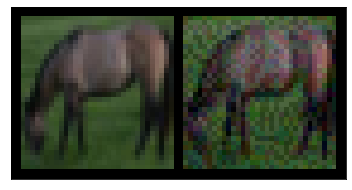

In [16]:
grid = make_grid([inverse_normalizer(instance_sample_clean), instance_sample_adv_denorm])
show(grid)

In [17]:
print(
    f"Clean True Label: {instance_label_clean.item()}, Clean Detected Label: {instance_victim_label_clean.item()}, Adversarial Detected Label: {instance_victim_label_adv.item()}"
)


Clean True Label: 7, Clean Detected Label: 7, Adversarial Detected Label: 6


## DIFFUSION TEST

In [18]:
defender = DEFENDER_DEFAULT_CONFIGS["DIFF"][TEST_DATASET]
aux_d_name = (
    TEST_DATASET + "_" + DEFENDER_DEFAULT_CONFIGS["DIFF"]["aux_d_type_for_diff"]
)
defender_diff, defender_diff_ema = load_diffusion_model(D_WEIGHTS[defender], defender)
_, defender_D, _ = load_gan_model(
    D_WEIGHTS[aux_d_name][0], D_WEIGHTS[aux_d_name][1], aux_d_name
)
defender_D.eval()
defender_diff.eval()
defender_diff_ema.eval();

In [19]:
losses, purified = diffusion_purify_untargeted(
    defender_diff_ema,
    instance_sample_adv_denorm.unsqueeze(0),
    NUM_CLASSES[TEST_DATASET],
    noise_steps=75,
    cond_scale=0.5
)


Diffusion Purify Untargeted: Calculating Losses: 100%|██████████| 1/1 [00:02<00:00,  2.38s/it]


In [20]:
losses

[0.004534577019512653]

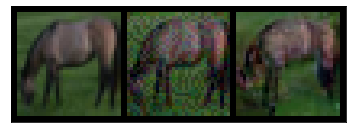

In [21]:
grid = make_grid(
    [inverse_normalizer(instance_sample_clean), instance_sample_adv_denorm, purified[0]]
)
show(grid)


In [22]:
victim(
    TF.normalize(
        purified[0].unsqueeze(0),
        mean=DEFAULT_MOMENTS[TEST_DATASET].mean,
        std=DEFAULT_MOMENTS[TEST_DATASET].std,
    )
).detach().argmax(1)


tensor([7], device='cuda:0')

## ACGAN TEST

In [23]:
defender = DEFENDER_DEFAULT_CONFIGS["ACGAN"][TEST_DATASET]
defender_G, defender_D, z_dim = load_gan_model(
    D_WEIGHTS[defender][0], D_WEIGHTS[defender][1], defender
)
defender_G.eval()
defender_D.eval();

In [24]:
losses, purified = acgan_purify_untargeted(
    defender_G,
    instance_sample_adv_denorm.unsqueeze(0),
    NUM_CLASSES[TEST_DATASET],
    z_dim,
    optimization_steps=100,
    optimizer_name="Adam",
    lr=0.1
)

ACGAN Purify Untargeted: Calculating Losses:   0%|          | 0/1 [00:00<?, ?it/s]

ACGAN Purify Untargeted: Calculating Losses: 100%|██████████| 1/1 [00:02<00:00,  2.65s/it]


In [25]:
losses

[0.07628639787435532]

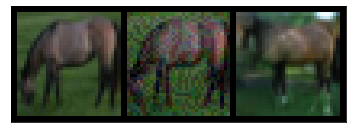

In [26]:
grid = make_grid(
    [inverse_normalizer(instance_sample_clean), instance_sample_adv_denorm, purified[0]]
)
show(grid)

In [27]:
victim(
    TF.normalize(
        purified[0].unsqueeze(0),
        mean=DEFAULT_MOMENTS[TEST_DATASET].mean,
        std=DEFAULT_MOMENTS[TEST_DATASET].std,
    )
).detach().argmax(1)

tensor([7], device='cuda:0')